100%|██████████| 9.91M/9.91M [00:00<00:00, 61.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.96MB/s]


Training...
Epoch [1/10], Loss: 0.0508
Epoch [2/10], Loss: 0.0289
Epoch [3/10], Loss: 0.0270
Epoch [4/10], Loss: 0.0208
Epoch [5/10], Loss: 0.0188
Epoch [6/10], Loss: 0.0177
Epoch [7/10], Loss: 0.0149
Epoch [8/10], Loss: 0.0134
Epoch [9/10], Loss: 0.0136
Epoch [10/10], Loss: 0.0111


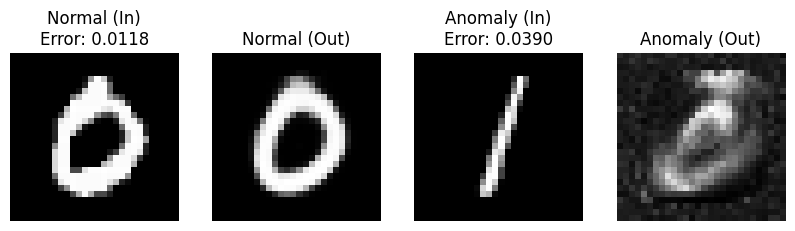

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 1. データ準備 (数字の '0' だけを正常データとして抽出)
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 0だけを取り出す
train_0 = [img for img, label in train_data if label == 0]
test_imgs = [img for img, label in test_data]
test_labels = [label for _, label in test_data]

train_loader = DataLoader(train_0, batch_size=64, shuffle=True)

# 2. オートエンコーダのモデル定義
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 圧縮
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        # 復元
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. 学習 (正常な '0' だけを覚えさせる)
print("Training...")
for epoch in range(10):
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

# 4. 検証 (正常な '0' と 異常な '1' を比較)
model.eval()
with torch.no_grad():
    # テストデータから '0'(正常) と '1'(異常) を1つずつ取得
    normal_img = [img for img, label in zip(test_imgs, test_labels) if label == 0][0]
    anomaly_img = [img for img, label in zip(test_imgs, test_labels) if label == 1][0]

    # 復元
    recon_normal = model(normal_img.unsqueeze(0))
    recon_anomaly = model(anomaly_img.unsqueeze(0))

    # 誤差計算 (MSE)
    err_normal = torch.mean((normal_img - recon_normal)**2).item()
    err_anomaly = torch.mean((anomaly_img - recon_anomaly)**2).item()

# 5. 結果の可視化
imgs = [normal_img, recon_normal[0], anomaly_img, recon_anomaly[0]]
titles = [f"Normal (In)\nError: {err_normal:.4f}", "Normal (Out)",
          f"Anomaly (In)\nError: {err_anomaly:.4f}", "Anomaly (Out)"]

plt.figure(figsize=(10, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()